In [2]:
import os
from os.path import join

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# 1.데이터 가져오기

In [47]:
data_dir = os.getenv('HOME')+'/Project/hackathon1/data'

# 파일명
# cats = join(data_dir, 'item_categories.csv')
# items = join(data_dir, 'items.csv') 
# shops = join(data_dir, 'shops.csv')
# train = join(data_dir, 'sales_train.csv') 
# test = join(data_dir, 'test.csv') 
# sample_submission = join(data_dir, 'sample_submission.csv') 

cats=pd.read_csv('./data/item_categories.csv')
items = pd.read_csv('./data/items.csv')
train=pd.read_csv('./data/sales_train.csv')
shops = pd.read_csv('./data/shops.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')


# # 데이터프레임
# cats = pd.read_csv(cats, encoding='utf-8')
# items = pd.read_csv(items, encoding='utf-8')
# shops = pd.read_csv(shops, encoding='utf-8')
# train = pd.read_csv(train, encoding='utf-8') # 훈련데이터셋
# test = pd.read_csv(test, encoding='utf-8') # 테스트데이터셋
# sample_submission = pd.read_csv(sample_submission, encoding='utf-8') #제출샘플 

# 1-1 시계열 EDA

In [48]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


from warnings import filterwarnings
filterwarnings('ignore')

In [49]:
train["date"]=pd.to_datetime(train["date"],format='%d.%m.%Y')

In [50]:
train["date"]

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]

각 일별로 grouping한 뒤에 item, "item_cnt_day"을 더한 뒤 나타내 보았습니다. 

In [51]:
train_datetime = train
train_datetime["date"]=pd.to_datetime(train_datetime["date"],format='%d.%m.%Y')



먼저 월간으로 통합하여 plot을 살펴보도록 하겠습니다. 

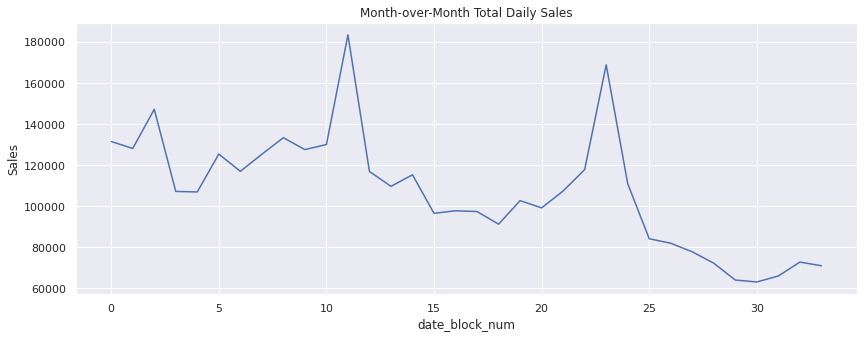

In [58]:
mom_sales = train_datetime.groupby(["date_block_num"])["item_cnt_day"].sum()
mom_sales.plot(kind="line",
                     xlabel="date_block_num",
                     ylabel="Sales",
                     title= "Month-over-Month Total Daily Sales",
                     figsize=(14,5));

전체적으로 하락하는 trend를 살표볼 수 있었습니다. 그리고 12,24쯤에 상승하는 강력한 seasonality를 살펴 볼수 있었습니다. 

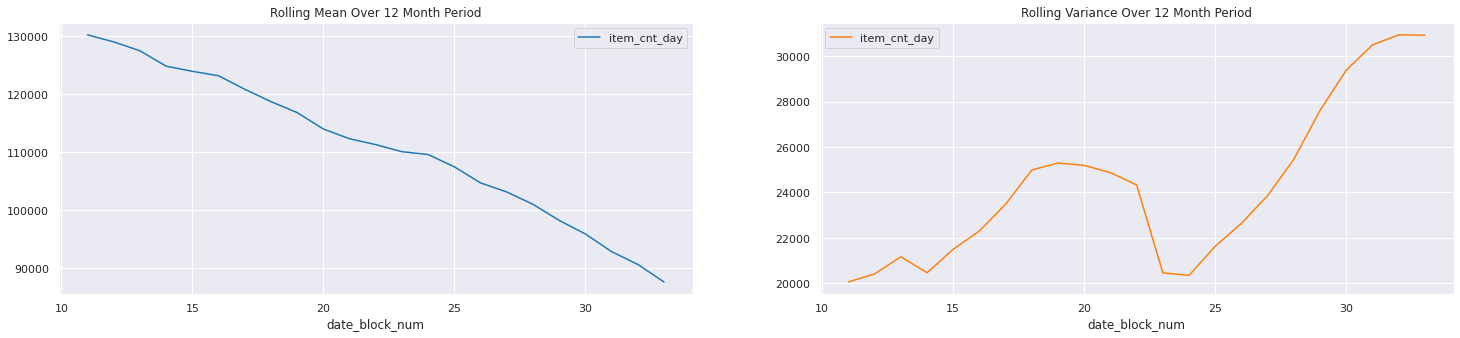

In [59]:
plt.subplot(121)
mom_sales.rolling(window = 12).mean().plot(figsize=(25,5), 
                                                 color="tab:blue", 
                                                 title="Rolling Mean Over 12 Month Period", 
                                                 legend = True);
plt.subplot(122)
mom_sales.rolling(window = 12).std().plot(color="tab:orange", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend=True);

moving average와 moving variance로도 전체적으로 하락하는 trend, 상승하는 variance를 볼 수 있었습니다.         
시계열 data의 variance를 측정하는것은 어렵습니다. 
때문에 보다 high-frequency 데이터를 통해서 살펴보기도합니다.         
[관련 링크](https://dspace.mit.edu/bitstream/handle/1721.1/47647/estimatingvarian00zhou.pdf?sequence=1)

그렇기 때문 저희는 월간보다 더 high_frequency한 일간 데이터를 eda해보았습니다.

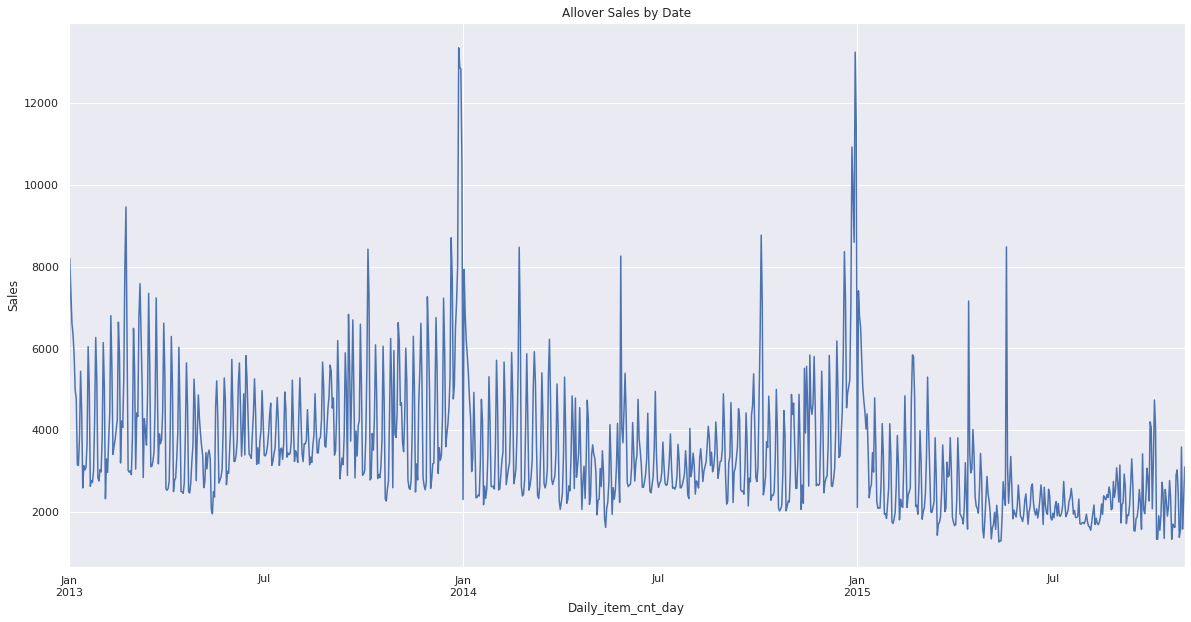

In [60]:
allover_sales_by_date = train_datetime.groupby(["date"])["item_cnt_day"].sum()
allover_sales_by_date.plot(kind="line",
                     xlabel="Daily_item_cnt_day",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(20,10));

date가 다소 noisy하기 때문에 살펴보기 힘들어서 moving하면서 값들을 계산해보았습니다.

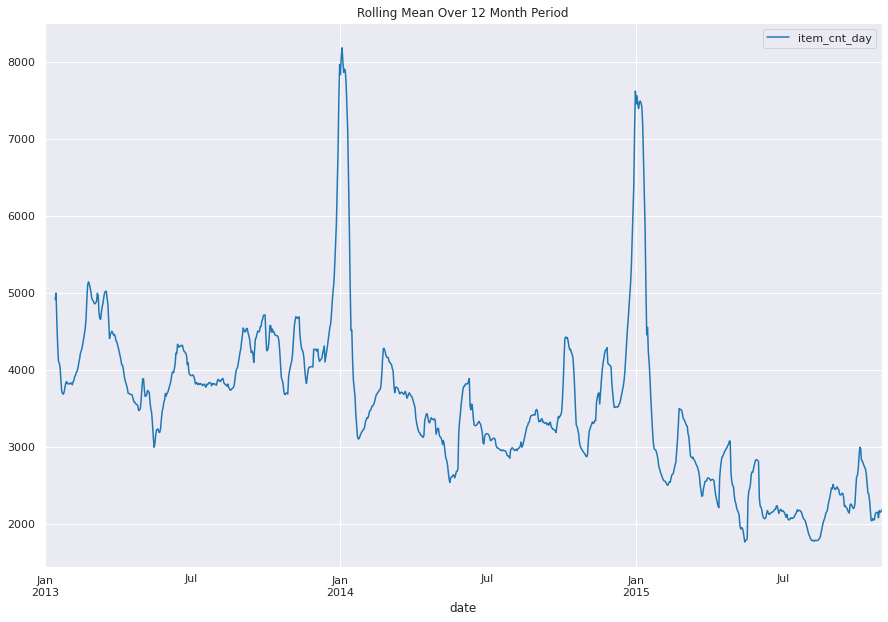

In [61]:
allover_sales_by_date.rolling(window = 14).mean().plot(figsize=(15,10), 
                                                 color="tab:blue", 
                                                 title="Rolling Mean Over 12 Month Period", 
                                                 legend = True);


일간 데이터를 2주단위의 moving average를 그려보았습니다. 

일간으로도 하강하는 trend와 연말혹은 연초의 높은 상승을 살펴 볼 수 있었습니다. 

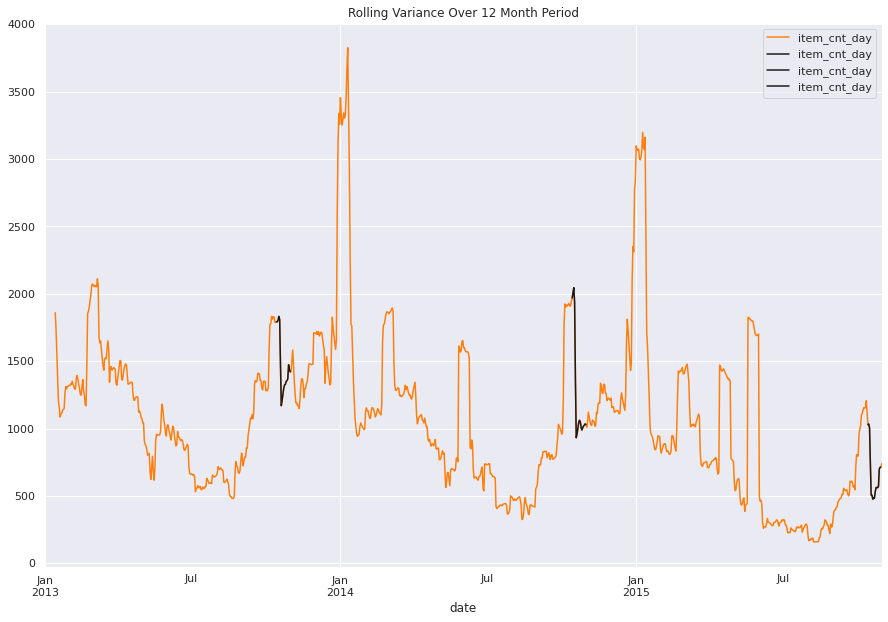

In [62]:
allover_sales_by_date.rolling(window = 14).std().plot(figsize=(15,10), color="tab:orange", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend=True);


allover_sales_by_date[273:304].rolling(window = 14).std().plot(figsize=(15,10), color="k", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend= "2013-10-01"),
# allover_sales_by_date[273:303]는 2013-10-01~31

allover_sales_by_date[638:669].rolling(window = 14).std().plot(figsize=(15,10), color="k", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend=True);

# allover_sales_by_date[638:669]는 2014-10-01~31

allover_sales_by_date[1003:1033].rolling(window = 14).std().plot(figsize=(15,10), color="k", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend=True,grid = True);

# allover_sales_by_date[1003:1033]는 2015-10-01~31



moving varaince도 2주마다 계산을 했을 때  역시 큰 변동이 있을 때마다 variance가 변동하는것을 보여줍니다. 

월간으로는 살펴보기 힘들었던 분산의 변화를 더 자세히 느낄 수 있습니다.     

2주간의 평균,과 분산을 통해 확실한 seasonality과 분산의 변동을 확인할 수 있었습니다.                  

검정색으로 표시된 부분은 좌측부터 2013-10-01\~31,  2014-10-01\~31 ,2015-10-01~31의 부분입니다. 

월간에서는 2015년 7,8,9월 점점 상승하는 분산만 관측할 수 있었지만

일간에서는 2015년 19월의 분산이 오히려 작아지는 경향을 파악할 수 있었습니다.                 
이는 월간 데이터를 통해서는 확인할 수 없었던 측면입니다.           


이때 일간 데이터를 더 자세히 분석하기위해서 seasonality의 freq를 어떻게 놓을지 대해서 고민하게 되었습니다.              
월마다 seaonalirty를 30일로 잡으면 각 달안에서의 seasonality을 잡아낼수있습니다.             
그러나 연말에 상승하는 sales은 trend로 잡히게 되고             
이는 우리 분석에 있어서 중대한 영향을 미치는 11월, 12월에 상승하는 sales를  잡지 못하게 될것이기 떄문입니다.

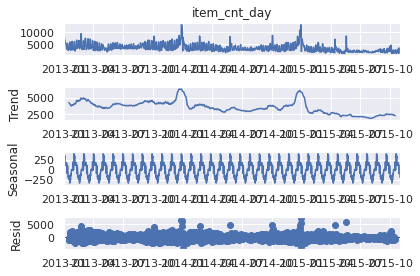

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose # seasonality 주기 30 

decompose_result = seasonal_decompose(allover_sales_by_date, freq= 30, model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

실제 확인해본 결과 주기 30은  년말의 seasonality를 잡지 못하고
이 부분이 trend로 옮겨간것을 확인할 수 있습니다.

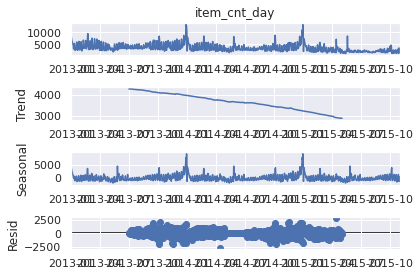

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose #계절성 주기 365

decompose_result = seasonal_decompose(allover_sales_by_date, freq= 365 , model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

반대로 계절성 주기를 365로 잡으면 위와 같이 계산할 수 있습니다.        
매년안에서의 계절성을 잡아낼수 있게 됩니다. (비교하자면 trend가 더 깔끔해졌음)

그러나 단점이 있습니다.

우리의 데이터가 2013,2014,2015년 일부의 데이터이기때문에                 
seasonality의 freq를 365로 결정한다면
각 365번의 주기가 2번 혹은 3번밖에 돌지않습니다.         
즉 겨우 2번, 3번의 기회로 seasonaltiy를 계산하게 됩니다. 이는 sample이 매우 적다는것을 의미하고 


즉 우리가 추정한 seasoanlity의 추정이 상대적으로 안정되지않은 값을 가지게 된다는 단점이 있습니다. 

<div style="width:48%; height:48%; float:left; 10px;">
<img src="./images/def_acf.png">
</div>

























> **acf(h)의 정의란?** $$X_{t}와 X_{t+h}의  correlation(자기상관성)$$


시차 h의 자기상관성(autocorrelation)을 알면 예측에 활용가능하기 때문에 살펴보는 것입니다.

<div style="width:48%; height:48%; float:left;">
<img src="./images/def_pacf.png">
</div>


> **pacf(h)의 정의란?** $$X_{t+1},X_{t+2},...,X_{t+h-1}가 주어졌을때의 X_{t}와 X_{t+h}의 조건부 correlation(자기상관성)$$

시차 h의 부분 자기상관성(partial autocorrelation)을 알면 예측에 활용가능하기 때문에 살펴보는 것입니다.

한번 우리 데이터의 acf와 pacf를 살펴보도록 하겠습니다.

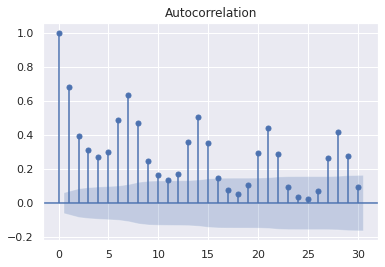

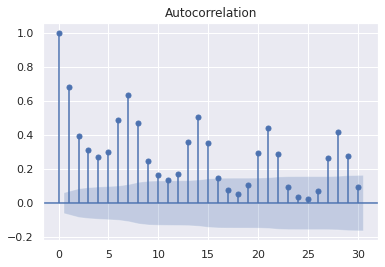

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


plot_acf(allover_sales_by_date, lags=30)

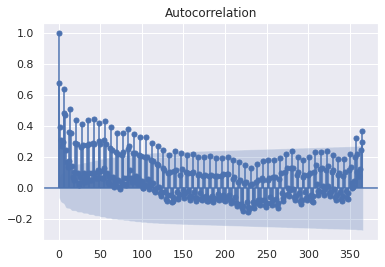

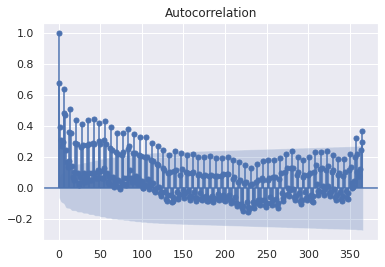

In [66]:
plot_acf(allover_sales_by_date, lags=365)

acf, pacf로도 분석할수있는데, lag가 150을 넘어가면서 점점 acf를 계산하는 sample size가 줄어들어       
신뢰구간 안으로 들어오게 되고, 신뢰할수없다는것을 나타냅니다.

아까 언급했듯이 우리 데이터는 2년 10개월치의 데이터인데, lag 150을 넘어가면 acf를 계산할 데이터의 숫자가 줄어들기 때문입니다.


> What you can see here are bars and a horizontal cone. This cone pictures the confidence level (by default set to 95%). In other words, if the point is outside the cone (on white) you may say that with 95% probability is has a certain impact on values. If the bar is inside the cone (on blue) you may ignore this particular lag as most likely it is not relevant. [출처](https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711)

pacf는 아래와 같습니다. 

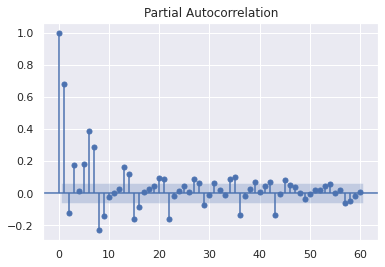

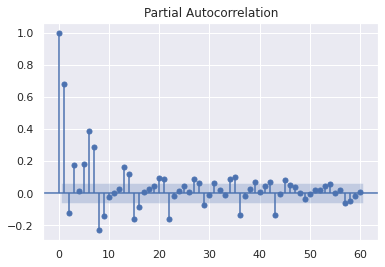

In [67]:
plot_pacf(allover_sales_by_date, lags=60)

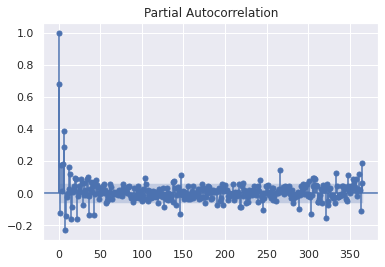

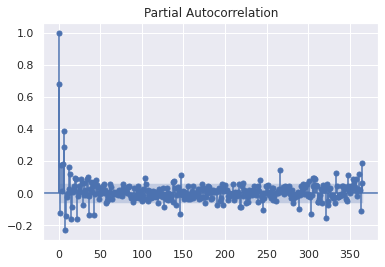

In [68]:
plot_pacf(allover_sales_by_date, lags=365)

pacf도 위와 같이 확인할 수 있었습니다. 

acf는 수치 뿐만 아니라 아예 scatter plot을 그려서 살펴볼수도 있습니다. 
lag15까지의 acf를 scat
ter plot을 통해서 살펴보겠습니다. 

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./images/linear_acf.png">
</div>


왜냐하면 ACF를 측정할때는 직관적으로 
$$(x_{1},x_{2},...,x_{n-h})와 (x_{h+1},x_{h+2},...,x_{n})$$

$$데이터셋의  linearity(선형성)$$을 의미하기 때문입니다.

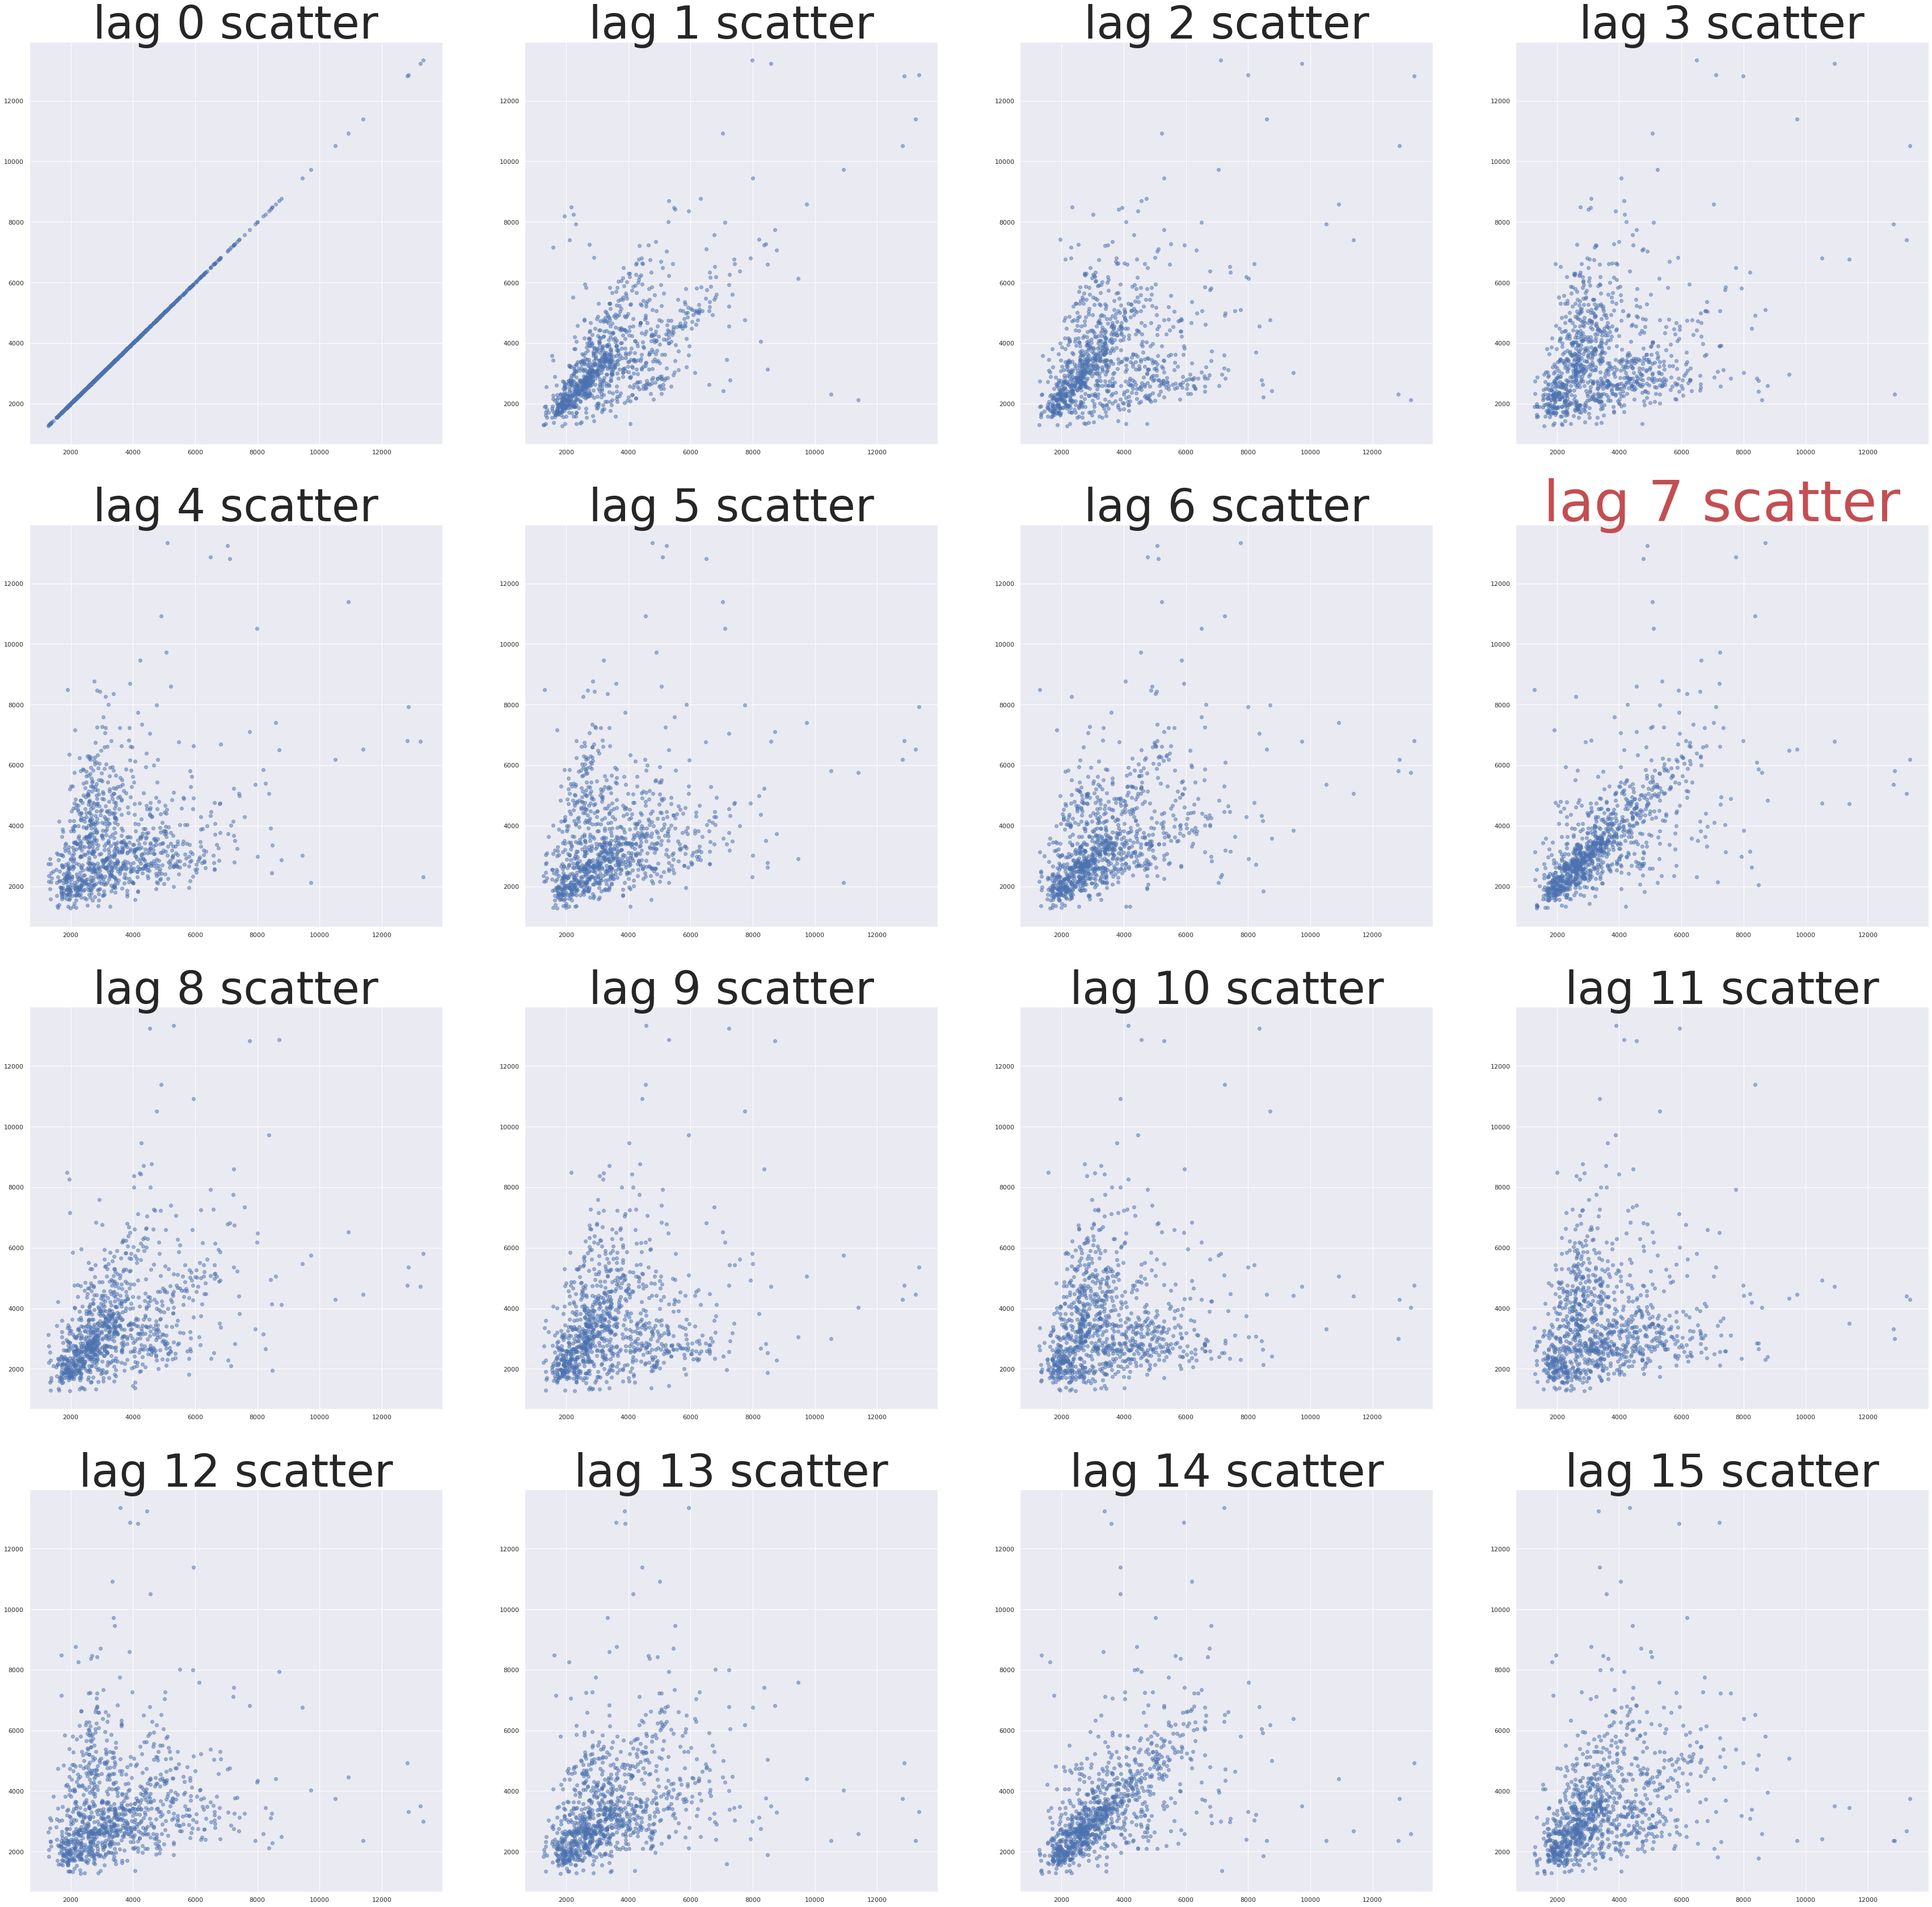

In [69]:
fig, ax = plt.subplots(4, 4, figsize=(60, 60))
for k in range(0,16):
    i,j = divmod(0+k,4)
    ax[0+i,0+j].scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)], alpha = 0.5)
    if k == 7:
        ax[0+i,0+j].set_title("lag " + str(k) + " scatter",fontsize= 100, c = "r" )
    else:    
        ax[0+i,0+j].set_title("lag " + str(k) + " scatter",fontsize= 80 )
    

plt.show()

lag 0은 자기 자신의 scatter plot이기때문에 **완벽한 선형성**을 보여줌을 확인하수 있습니다.

다른 lag들을 살펴보면

아까 acf로 확인했듯이 **lag가 7**인 경우에 강한 선형 상관관계가 있음을 확인할 수 있었습니다.

이번에는 0,7,30,365 lag의 scatter plot을 그려보도록하겠습니다.

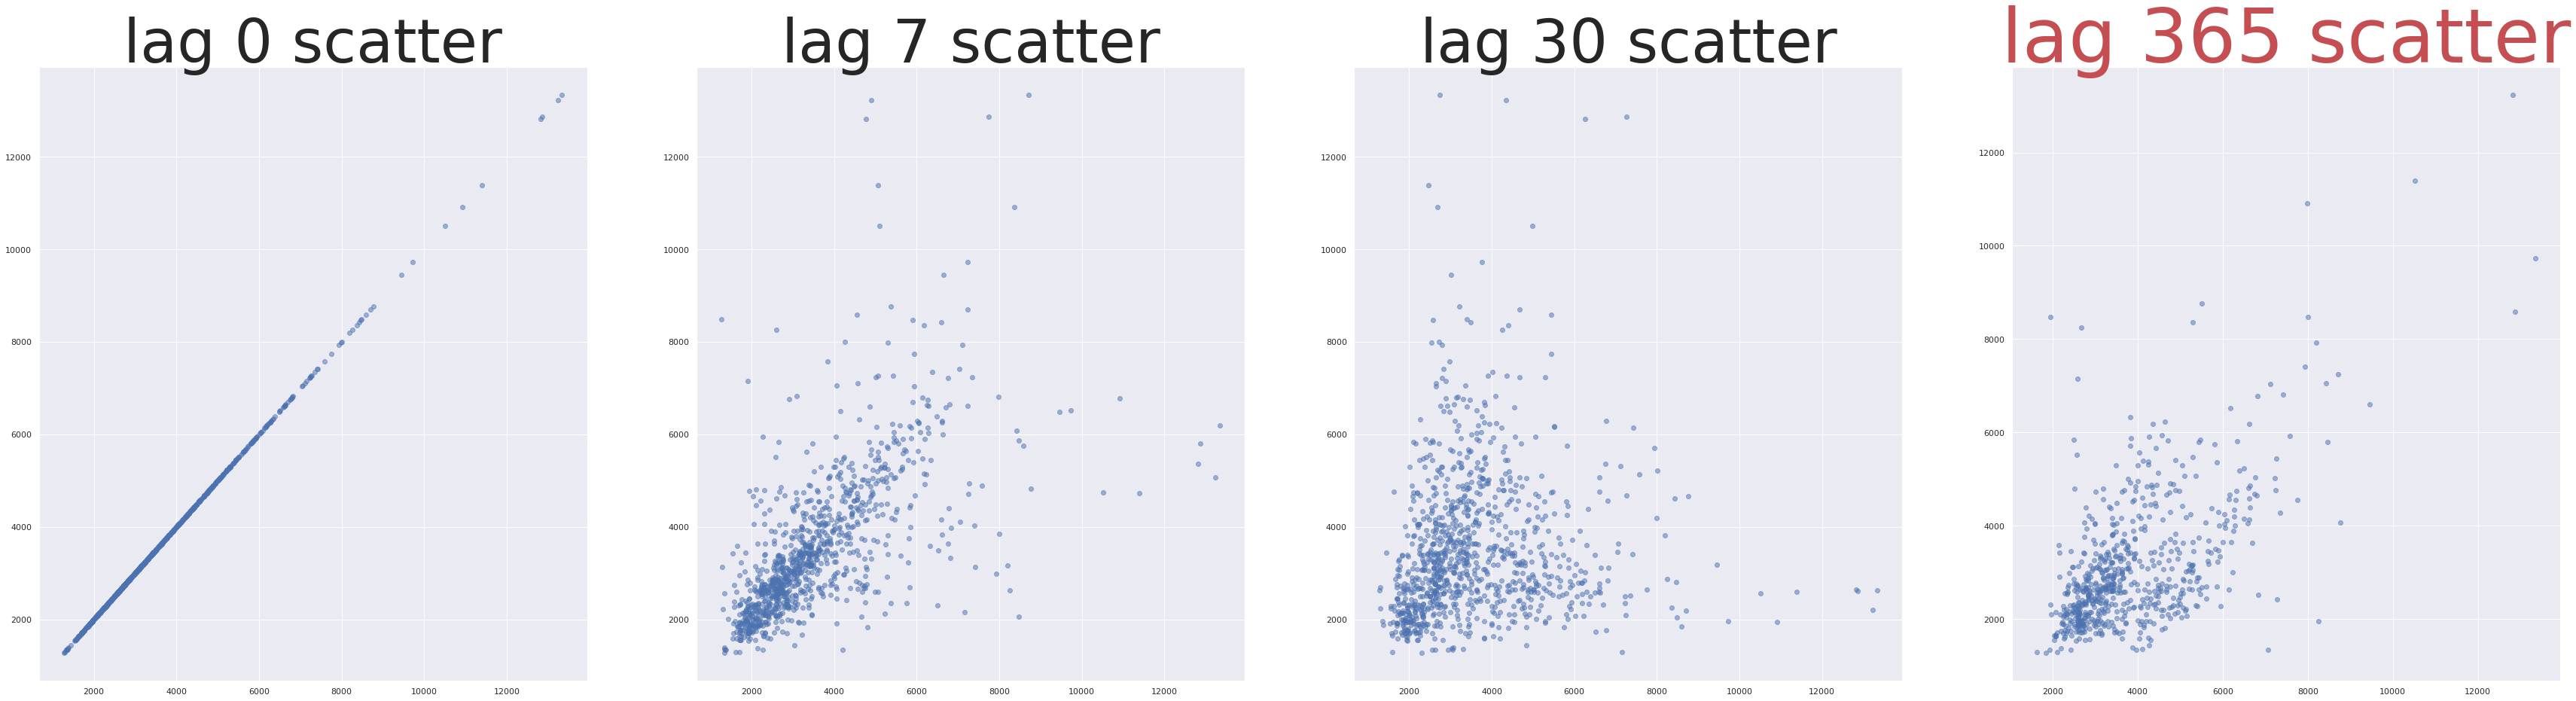

In [70]:
fig, ax = plt.subplots(1, 4, figsize=(60, 15))
i = 0 
for k in [0,7,30,365]:
    ax[0+i].scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)], alpha = 0.5)
    if k == 365:
        ax[0+i].set_title("lag " + str(k) + " scatter",fontsize= 100, c = "r" )
    else:    
        ax[0+i].set_title("lag " + str(k) + " scatter",fontsize= 80 )
    
    i += 1 
plt.show()

여기서 30과 비교했을때 365의 scatterplot이 상대적으로 강한 선형석을 보이는것을 확인할 수 있습니다.
이를  더 자세히 살펴보도록 하겠습니다. 

In [71]:
k = 365

시계열 데이터이기때문에 scatter plot이 어느 시간대의 data인지 살펴봄으로서 
더 심도있게 살펴볼 수 있습니다.

저희의 목적은 2015년 11월을 예측하는 것이기 때문에 13,14년 oct, nov, dec 의 점들을 살펴보도록 하겠습니다.

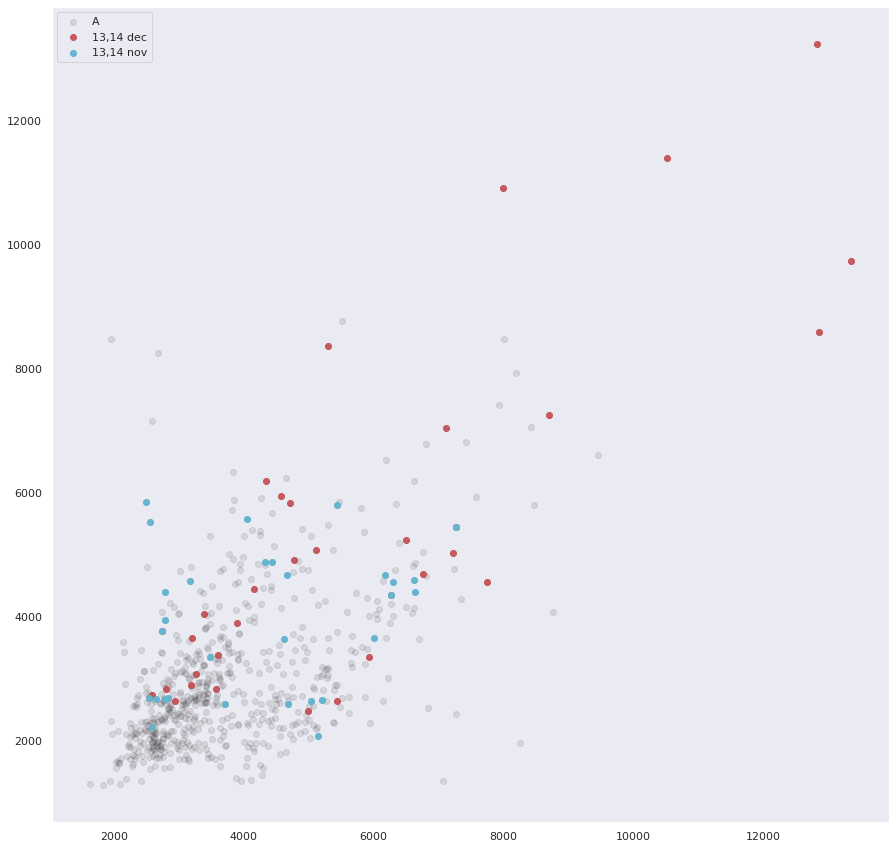

In [72]:
fig = plt.figure(figsize=(15,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
# ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)])
ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)],label='A',c = 'k', alpha = 0.1) ## 선그래프 생성
# ax.scatter(allover_sales_by_date[0:30],allover_sales_by_date[(0+k):(30+k)],label='Early',c= 'g', alpha = 0.05) ## 선그래프 생성

ax.scatter(allover_sales_by_date[330:365],allover_sales_by_date[(330+k):(365+k)],label='13,14 dec',c = 'r',alpha = 0.9) ## 선그래프 생성
ax.scatter(allover_sales_by_date[304:334],allover_sales_by_date[(304+k):(334+k)],label='13,14 nov',c = 'c',alpha = 1) ## 선그래프 생성



plt.grid()
plt.legend()

13,14의 dec는 13년 값은 작지만 14년 값은 크거나 13년 값은 큰데 

14년 값은 작은 여러 데이터들이 있어 상대적으로 **약한 선형성**을 보여줍니다.


반면에 13,14년의 nov은 상대적으로 **강한 선형성**을 보여줍니다.

> 선형성은 acf를 보여줍니다.

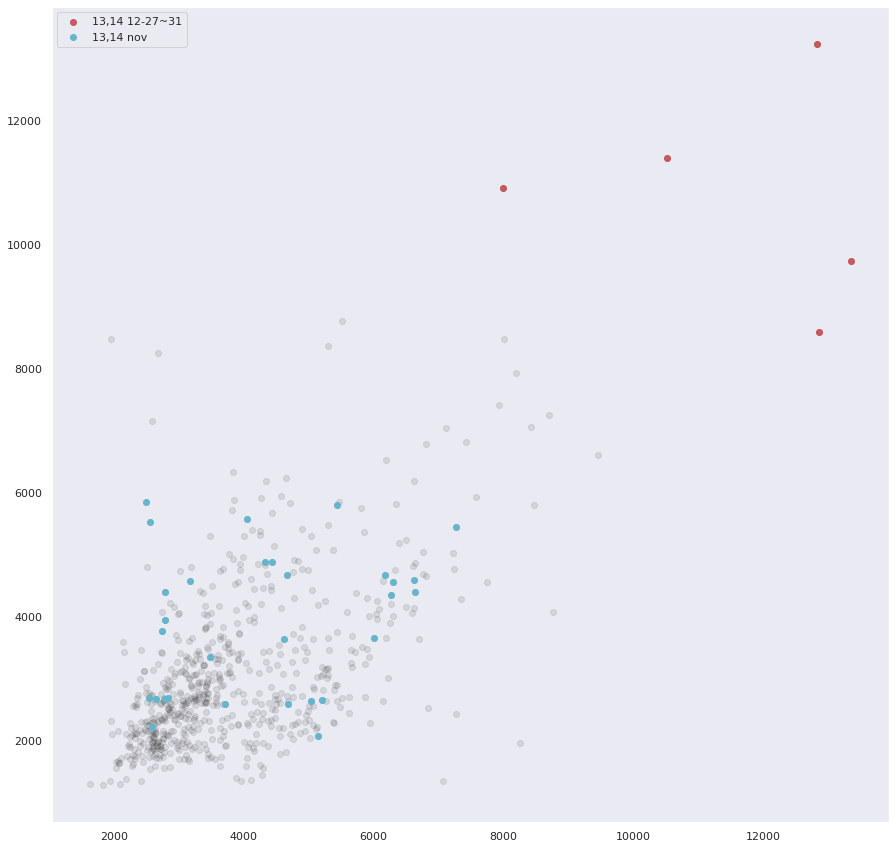

In [73]:
fig = plt.figure(figsize=(15,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
# ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)])
ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)],alpha = 0.1, c = "k") ## 선그래프 생성
# ax.scatter(allover_sales_by_date[0:30],allover_sales_by_date[(0+k):(30+k)],label='Early',c= 'g', alpha = 0.05) ## 선그래프 생성
ax.scatter(allover_sales_by_date[360:365],allover_sales_by_date[(360+k):(365+k)],label='13,14 12-27~31',c = 'r',alpha = 0.9) ## 선그래프 생성
ax.scatter(allover_sales_by_date[304:334],allover_sales_by_date[(304+k):(334+k)],label='13,14 nov',c = 'c',alpha = 1) ## 선그래프 생성
# ax.scatter(allover_sales_by_date[304:334],allover_sales_by_date[(304+k):(334+k)],label='14,15 nov',c = 'k',alpha = 1) ## 선그래프 생성


plt.grid()
plt.legend()

그 중에서도 13년 12월 27\~31과 14년 12월 27\~31 즉 **연말일** 에 가까운 scatter 들이 
양의 상관관계를 보이는것을 확인할 수 있습니다.


다음은 우리가 예측할 nov의 바로 전달인 oct의 scatter plot을 살펴보겠습니다.

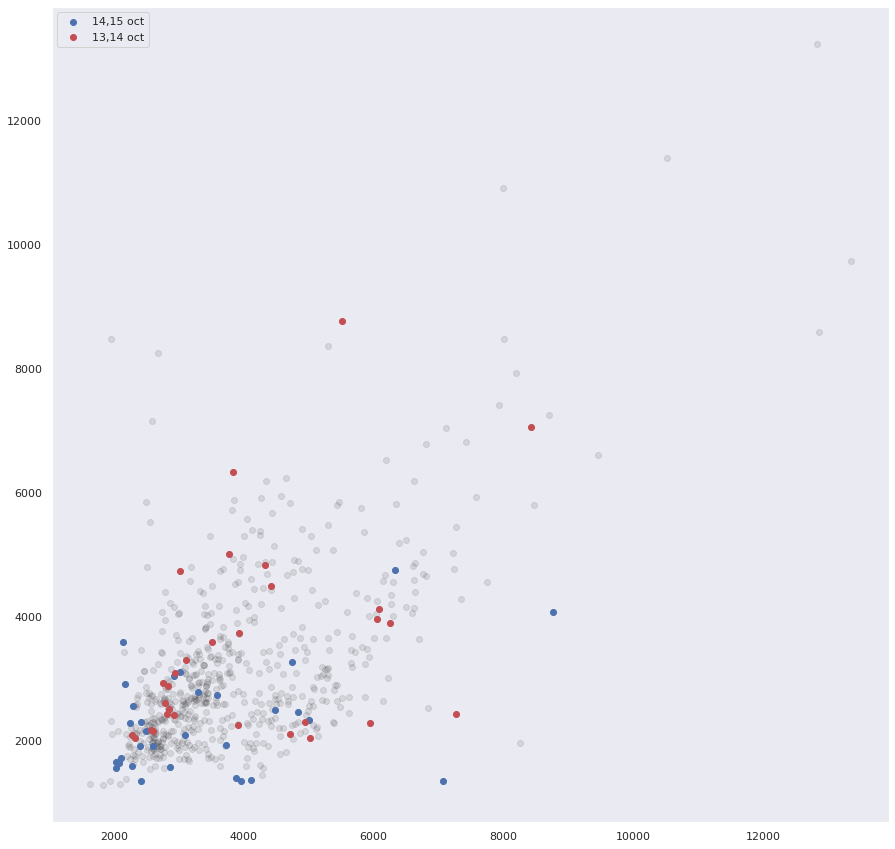

In [74]:
fig = plt.figure(figsize=(15,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)],alpha = 0.1, c = "k") ## 선그래프 생성
ax.scatter(allover_sales_by_date[638:669],allover_sales_by_date[(638+k):(669+k)],label='14,15 oct',c = 'b',alpha = 1) ## 선그래프 생성
ax.scatter(allover_sales_by_date[273:303],allover_sales_by_date[(273+k):(303+k)],label='13,14 oct',c = 'r',alpha = 1) ## 선그래프 생성


plt.grid()
plt.legend()

상대적으로 최신인 14년,15년의 oct끼리 선형의 상관성이 깨지고 있음을 확인할수있습니다.

이는 14년도 값은 크지만 15년도 값은 작은것의 영향을 받고 있습니다.

이는 점차 낮아지고 있는 trend의 영향으로 해석할 수 있습니다.

# 이렇게 보고도 일별로 못한 이유

``` python 
train_datetime.loc[train_datetime['item_id'].isin(test_item_id_list) ].groupby("item_id").plot(x = "date", y = "item_cnt_day", alpha = 0.4)
```

<div style="width:48%; height:48%; float:left; 10px;">
<img src="./images/cant.png">
</div>


shop_id, item_id 별 매일 item_cnt_day를 계산해야하는데 매일 판매량이 존재하지않은 것들(결측치)이 상당수 존재하여서
11월 1일부터 11월 30일까지의 일별 판매량을 계산한후 모두 합산에 월별 판매량을 구하는것은 어렵다고 판단되었습니다. 
그래서 일별 데이터는 활용하지 못했습니다. 

하지만 일별 데이터를 활용한 EDA를 통해 시계열 데이터의 특성을 살필 수 있던 의의가 있었다고 생각합니다.

# 2. 테이블별 데이터 정제

## 2-1. sales_train 데이터셋 정제 (train)

In [8]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


- item_cnt_day 와 item_price 의 이상치를 확인한 후 제거

<AxesSubplot:xlabel='item_price'>

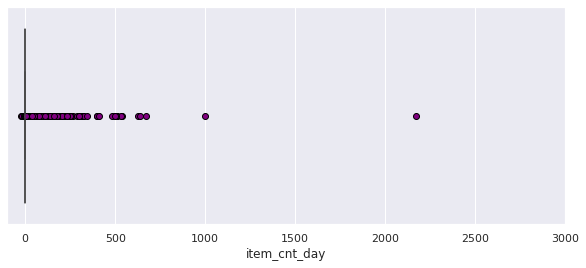

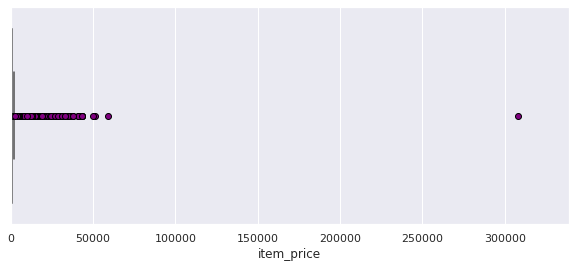

In [10]:
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')

# item 판매 갯수
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

# item 판매 가격
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

item_cnt_day(판매 된 제품 수) item_price(상품의 현재 가격)의 이상치에 대해서 더 탐구해보고자 하였습니다. 

이상치들은 아래와 같습니다.

In [11]:
train[train.item_cnt_day >= 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [12]:
train[train.item_price>= 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [13]:
train_datetime = train
train_datetime["date"]=pd.to_datetime(train["date"],format='%d.%m.%Y')

각각을 제대로 탐구하기위해서 train 데이터의 date 열을 to_datetime을 통해 바꾸어주었습니다.

<AxesSubplot:title={'center':'Allover Sales by Date'}, xlabel='Days', ylabel='Sales'>

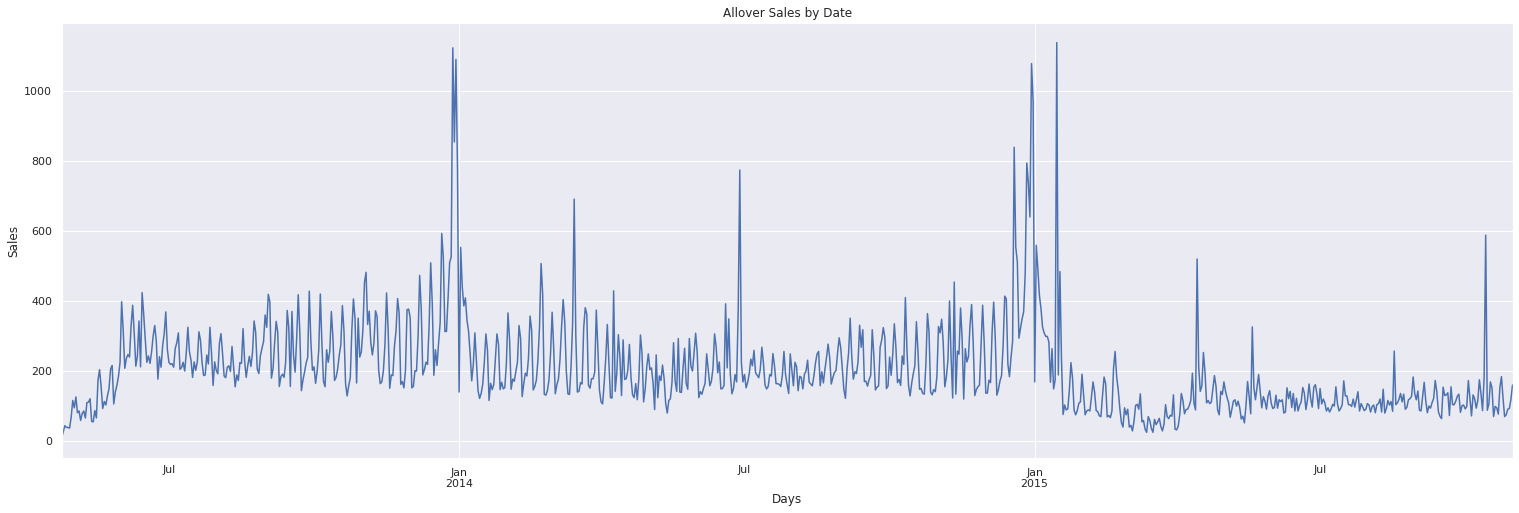

In [14]:
outlier_1 = train_datetime[train_datetime["item_id"] == 20949].groupby("date")['item_cnt_day'].sum()
outlier_1.plot(kind="line",
                    xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(26,8))

item id 20949는 일자별로 합산했을때는 괜찮은 값이라고 판단되었습니다.

In [19]:
items[items.item_id == 20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


<div style="width:48%; height:48%; float:left;">
<img src="./images/trash.png">
</div>


하지만 쓰레기봉투가 하루에 1000매 팔리는것은 극히 이상치로 예측에 도움이 되지않는다고 판단하고 삭제하였습니다.

<AxesSubplot:title={'center':'Allover Sales by Date'}, xlabel='Days', ylabel='Sales'>

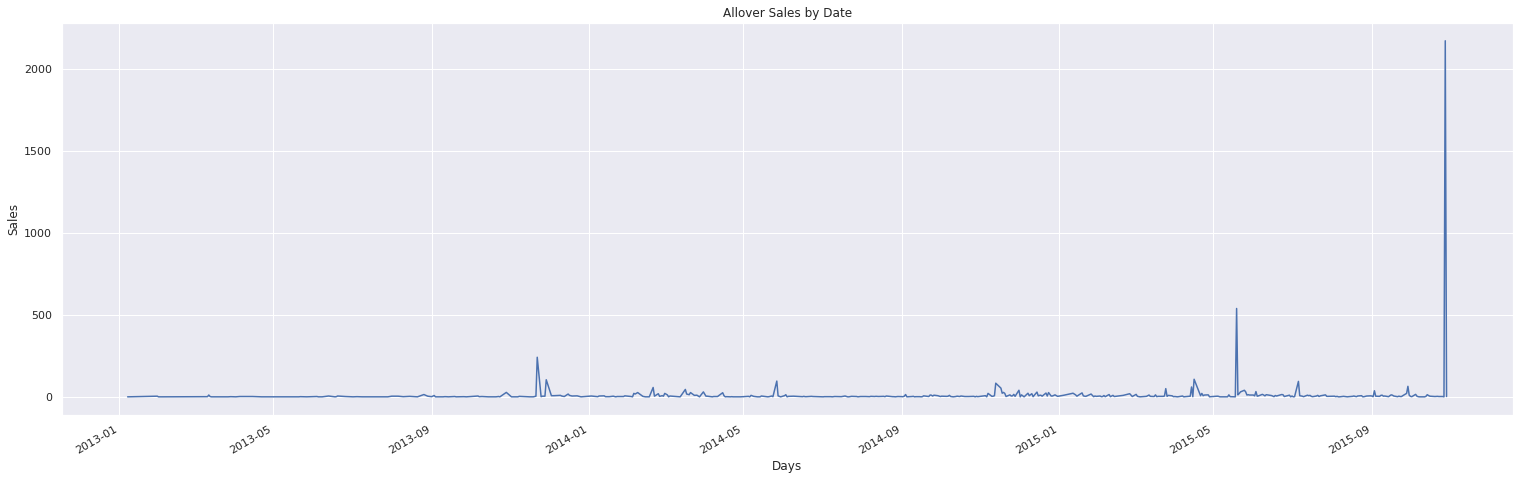

In [16]:
outlier_2 = train_datetime[train_datetime["item_id"] == 11373].groupby("date")['item_cnt_day'].sum()
outlier_2.plot(kind="line",
                    xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(26,8))

item_id 1373의 경우에는 날짤별로 grouping한후 전체 shop의 item_cnt_day를 더하고도

500이상의 item_cnt_day을 가졌던 적이 없습니다.

그러나 2015-10-28영레 shop_id 12번에서 2169의 극히 높은 판매량을 보였습니다.

그러므로 이를 이상치라고 보고 삭제하였습니다.

In [18]:
print(train[train["item_id"] == 6066] , "- \n---\n---\n---\n",test[test["item_id"] == 6066])

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
1163158 2013-12-13              11       12     6066    307980.0           1.0 - 
---
---
---
 Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []



item_id 6066는 train data에 단 한번 등장하는 data입니다.

300000루블이라는 지나치게 높은 값을 가지고 있었습니다.

category는 Program - For home and office 이고 item_name은 영어로 Radmin 3 - 522 persons. 였습니다.

test data에는 등장하지않는 데이터이기때문에 삭제하는 것으로 결정하였습니다.

In [114]:
# 이상치 삭제
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

In [115]:
train[(train.item_cnt_day >= 1000 )]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


shop_id 12는 러시아지역에서 상점 위치를 찾을 수가 없었다. 매장이 사라진거 같다. 튀는 값은 삭제 
300000루블이상 제거 한건 (category는 Program - For home and office) (item_name은 Radmin 3 - 522 persons.	)
1000

- shop_id 12는 현재 기준 매장이 폐업을 한것으로 예측되어지므로 판매예측값에 포함해서 결과를 가져가기에는 맞지 않은 값이라 판단하여 제거하였습니다.

In [116]:
train[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [117]:
train[train.item_cnt_day < 1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-10-05,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


In [118]:
len(train[train.item_cnt_day < 1])/len(train) 

0.0025055810148079975


itemp_price가 -1.0 혹은 item_cnt_day가 음수로 측정된 데이터도 있었습니다.

이들은 sales라기보다는 환불 거래를 기록한것으로 추측할 수 있었습니다.

전체 데이터 셋에서 0.2%의 작은 비율을 차지하고 있었기 때문에

저희의 분석에는 큰 의미가 없다고 보고 삭제하는 것으로 결정하였습니다.

In [119]:
# item_price 가 음수이면 환불일 수 있을거 같다. 삭제
# item_cnt_day 가 음수이면 0 으로 세팅
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [120]:
# revenue(수익) 컬럼 추가
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [121]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
2,2013-01-05,0,25,2552,899.00,0.0,0.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00


revenue(수익) 컬럼을 추가하였습니다.

## 2-2. shops 데이터셋 정제

In [122]:
shops.head() # 정제 전

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [123]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


- shop_id 재설정 ??

                       shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0                   shop_name  shop_id
57  Якутск Орджоникидзе, 56       57


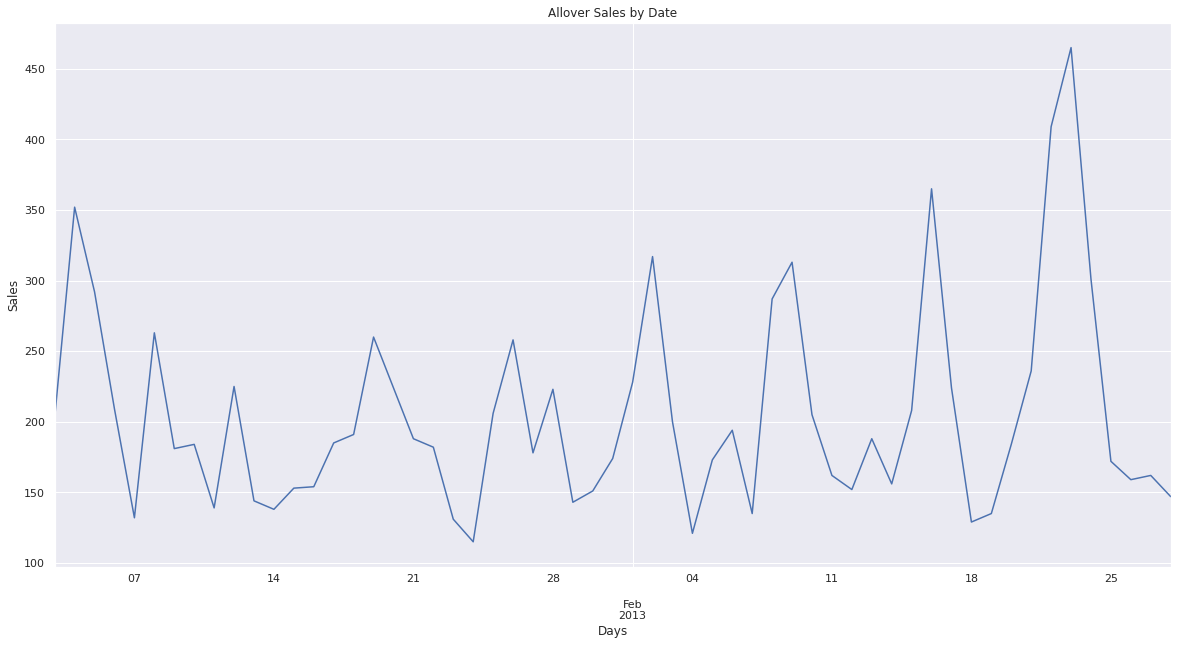

In [22]:

shop_relocate_1 = train_datetime.loc[train_datetime.shop_id == 0].groupby("date")['item_cnt_day'].sum()
shop_relocate_1 .plot(kind="line",
                    xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(20,10))


print(shops.loc[shops.shop_id == 0], shops.loc[shops.shop_id == 57] )


가게 id 0은 오직 2013년 1,2월의 거래기록만 가지고 있었습니다.

또한 shop_name이 가게 id 57과 ! 하나 차이만(!Якутск Орджоникидзе , Якутск Орджоникидзе) 을 가지고 있었습니다.

그렇기 때문에 이를 단순 오차로 보고 가게 id 0을 모두 가게 id 57로 통합하였습니다.

                       shop_name  shop_id
1  !Якутск ТЦ "Центральный" фран        1                   shop_name  shop_id
58  Якутск ТЦ "Центральный"       58


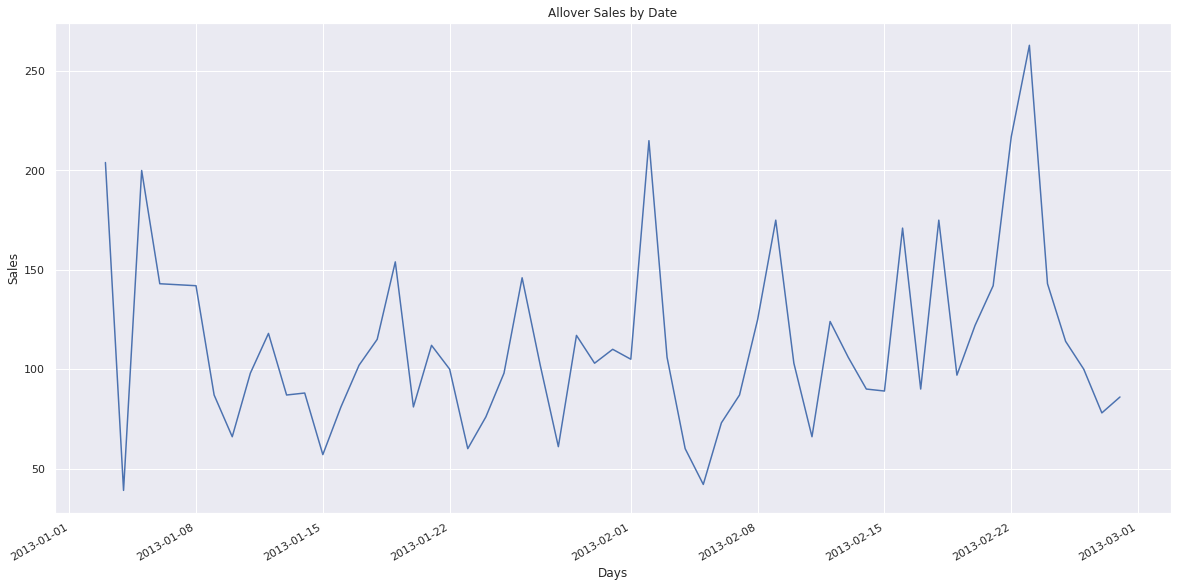

In [23]:
shop_relocate_2 = train_datetime.loc[train_datetime.shop_id == 1].groupby("date")['item_cnt_day'].sum()
shop_relocate_2 .plot(kind="line",
                    xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(20,10))


print(shops.loc[shops.shop_id == 1], shops.loc[shops.shop_id == 58] )


가게 id 1 역시 비슷하게 오직 2013년 1,2월의 거래기록만 가지고 있었습니다.

또한 shop_name이 가게 id 58과 !와 фран 차이만(!Якутск ТЦ "Центральный" фран , Якутск ТЦ "Центральный") 을 가지고 있었습니다.

그렇기 때문에 이를 단순 오차나 가게 통폐합으로 보고 가게 id 1을 모두 가게 id 58로 통합하였습니다.

                     shop_name  shop_id
10  Жуковский ул. Чкалова 39м?       10                      shop_name  shop_id
11  Жуковский ул. Чкалова 39м²       11


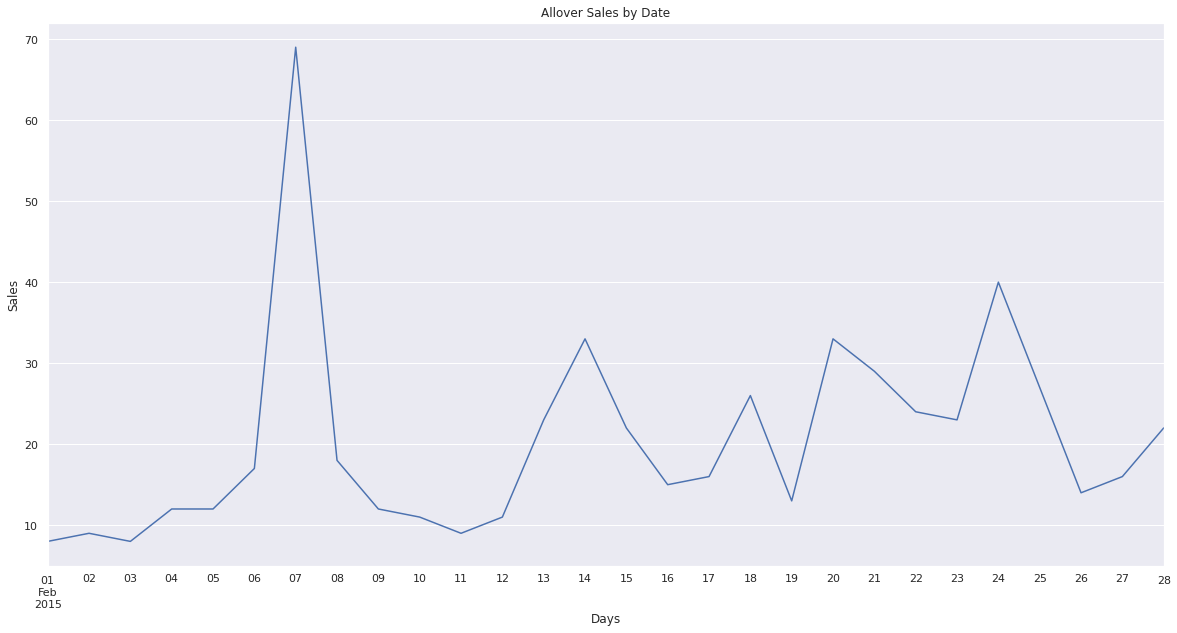

In [24]:

shop_relocate_3 = train_datetime.loc[train_datetime.shop_id == 11].groupby("date")['item_cnt_day'].sum()
shop_relocate_3 .plot(kind="line",
                    xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(20,10))


print(shops.loc[shops.shop_id == 10], shops.loc[shops.shop_id == 11] )


가게 id 11 역시 비슷하게 오직 2015년 1월의 거래기록만 가지고 있었습니다.

또한 shop_name이 가게 id 58과 ?와 ² 차이만(Жуковский ул. Чкалова 39м? , Жуковский ул. Чкалова 39м²) 을 가지고 있었습니다.

그렇기 때문에 이를 단순 오차나 가게 통폐합으로 보고 가게 id 10을 모두 가게 id 11로 통합하였습니다.

지금까지 설명한 내용들을 아래와 같이 통합하였습니다. 

In [25]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

- shop_name 을 공백을 기준으로 city와 category로 분리 

In [125]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"' # 도시 이름이 떨어져 있는거 붙여주기 
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск" # 도시 이름에 ! 들어간거 정제

In [126]:
shops.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', '(Плехановская,', 'Торговля',
       'ул.', 'ЧС', '"Распродажа"', 'МТРЦ', 'Магазин', 'ТК', 'склад'],
      dtype=object)

- 상점이 5개 이상인 것만 카테고리로 분류하고 나머지는 other 로 정제하였습니다,

In [127]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [128]:
shops.category.unique() 

array(['other', 'ТЦ', 'ТРК', 'ТРЦ', 'ТК'], dtype=object)

In [129]:
shops.head() # 정제 후

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,other
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


## 2-3. item_categories 데이터셋 정제 (cats)

In [37]:
cats.head() # 정제 전

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [38]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


- item_category_name 공백을 기준으로 type 과 category 로 분리

In [40]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str) 
cats.loc[(cats.type_code == "Аксессуары")]

,item_category_name,item_category_id,type_code
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
5,Аксессуары - PSVita,5,Аксессуары
6,Аксессуары - XBOX 360,6,Аксессуары
7,Аксессуары - XBOX ONE,7,Аксессуары


type_code Аксессуар(액세사리)는 모두 PS2,PS3,PSP같은 콘솔 게임기의 액세서리를 나타내고 있습니다.        
그러므로 이를 Игровые(Gaming)과 통합하여 "Игры"로 catergory를 통합하였습니다.

In [41]:

cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры" 
#"Игровые"(영문:'Gaming') 과 "Аксессуары"(영문:'Accessories')는 "Игры" (영문:'Games')으로 통합

In [42]:
cats.type_code.unique()

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype=object)

In [134]:
cats.category.unique()

array([nan, 'Игры'], dtype=object)

- type_code이 5개 이상인 것만 카테고리로 분류하고 나머지는 other 로 정제하였습니다.

In [43]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [45]:
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats = cats[["item_category_id", "item_category_name", "subtype", "type_code"]]

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
cats # 정제 후

,item_category_id,item_category_name,subtype,type_code
0,0,PC - Гарнитуры/Наушники,Гарнитуры/Наушники,etc
1,1,Аксессуары - PS2,PS2,Аксессуары
2,2,Аксессуары - PS3,PS3,Аксессуары
3,3,Аксессуары - PS4,PS4,Аксессуары
4,4,Аксессуары - PSP,PSP,Аксессуары
...,...,...,...,...
79,79,Служебные,Служебные,etc
80,80,Служебные - Билеты,Билеты,etc
81,81,Чистые носители (шпиль),Чистые носители (шпиль),etc
82,82,Чистые носители (штучные),Чистые носители (штучные),etc


조인해서 각 범주별로 어떻게 분포되어있는지 분포 그려보기 

## 2-4. items 데이터셋 정제

In [138]:
items.head() # 정제 전

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [139]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


- name 정제

In [140]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [141]:
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.
/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [142]:
#items.head()

In [143]:
# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

In [144]:
#items.head(10)

In [145]:
# fill nulls with '0'
items = items.fillna('0')

In [146]:
#items.head()

In [147]:
# item_name 컬럼을 위 함수로 정제시킴
items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

In [148]:
#items.head()

In [149]:
# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

In [150]:
#items.head(15)

In [151]:
# items_name2를 분리해 type컬럼을 만들고, 비슷한 의미의 type은 하나로 정제 시킴
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

게임기 xbox360에 오타나 띄어쓰기 잘못된것을 통합함.
공백은 왜 mac으로 고쳤는지 파악할 필요가 있음.
나머지는 확인해야할듯

In [152]:
items.type.unique()

array(['0', 'pc', 'ps3', 'xbox360', 'цифровая', 'mac', 'psp', 'ps4',
       'xboxone', 'ps', 'русская', 'рс', 'android', 'англ', 'ps2',
       'только', 'цифро', '6jv', 'j72', 'hm3', 's3v', '6dv', '6l6', '5f4',
       's4v', 'kg4', '5c5', '5c7', 'kf7', 'kf6'], dtype=object)

In [153]:
#items.head()

In [154]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

왜 40 이하는  other 처리했는지 정리해야함

In [155]:
items.head() # 정제 후 

,item_name,item_id,item_category_id,name1,name2,name3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d


이렇게 전처리한걸로 분포를 eda를통해 확인해볼것

# 3. LabelEncoding

In [156]:
from sklearn.preprocessing import LabelEncoder ## 범주형 데이터를 0부터 시작하는 정수형식으로 바꿔준다.

In [157]:
# shops LabelEncoding
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]
shops.head()

,shop_id,shop_category,shop_city
0,0,0,29
1,1,4,29
2,2,4,0
3,3,2,1
4,4,4,2


In [158]:
# cats LabelEncoding 
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["subtype_code"] = LabelEncoder().fit_transform( cats.subtype )
cats = cats[["item_category_id", "subtype_code", "type_code"]]
cats.head()

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1


In [159]:
# items labelEncoding
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


# 4. matrix 만들기

Create a matrix df with every combination of month, shop and item in order of increasing month.    
month가 증가하는 순으로 shop과 item, month가 매번 조합하여 matrix를 생성한다. 

In [160]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )
    # month, shop, item 조합하여 matrix 구성

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

7.861630439758301

In [161]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


Item_cnt_day is summed into an item_cnt_month.  
item_cnt_day는 item_cnt_month에 따라 sum 된다.

## item_cnt_month 추가

In [162]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} ) # groupby 기준에 따라 item_cnt_day를 sum
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" ) 
# matrix와 위에서 구한 group 을 조인하여 item_cnt_month를 생성. 조인 기준은 cols  = ["date_block_num", "shop_id", "item_id"]
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

2.8619558811187744

In [163]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [164]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

matrix와 test 를 왜 concat 할까?
keys 는 cols =  ["date_block_num", "shop_id", "item_id"]

In [165]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.047345876693725586

In [166]:
# matrix 데이터셋과 shops, items, cats 조인
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

2.635215997695923

In [167]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code
0,0,2,19,0.0,4,0,40,4,42,4,5
1,0,2,27,1.0,4,0,19,76,42,10,3
2,0,2,28,0.0,4,0,30,107,42,55,3
3,0,2,29,0.0,4,0,23,123,42,16,3
4,0,2,32,0.0,4,0,40,4,42,4,5


# 6. Feature Engineering

lag feature 와 그 외 필요 feature 추가

## 6-0. lag feature 추가 함수

In [168]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]] # df는 matrix, 컬럼을 재설정하여 tmp 생성
        for i in lags:
            shifted = tmp.copy() # shifted로 copy
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)] # shifted 에 lags 순으로 cols 를 다시 구성
            shifted.date_block_num = shifted.date_block_num + i # lag 만큼 date_block_num을 더함.
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left') # lag가 구성된 shifted와 df 조인
    return df

## 6-1. item_cnt_month_1, _2, _3 

In [169]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


12.573597192764282

In [170]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,2,19,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN
1,0,2,27,1.0,4,0,19,76,42,10,3,NaN,NaN,NaN
2,0,2,28,0.0,4,0,30,107,42,55,3,NaN,NaN,NaN
3,0,2,29,0.0,4,0,23,123,42,16,3,NaN,NaN,NaN
4,0,2,32,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN


## 6-2. date_avg_item_cnt _1 (월별 평균)
(Add the previous month's average item_cnt. 왜 이전이지? 위에 lag_feature() 함수에서는 date_block_num + lag 를 하는데... )

In [171]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


6.2100160121917725

In [173]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1
11127994,34,45,3280,0.0,4,20,55,4,42,2,7,0.0,0.0,0.0,0.289795
11127995,34,45,4393,0.0,4,20,22,70,42,14,3,0.0,0.0,0.0,0.289795
11127996,34,45,4352,0.0,4,20,22,70,42,14,3,0.0,0.0,0.0,0.289795
11127997,34,45,18049,0.0,4,20,70,4,42,57,8,0.0,0.0,0.0,0.289795
11127998,34,45,18027,0.0,4,20,70,4,42,57,8,0.0,0.0,0.0,0.289795
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,1.0,0.0,0.0,0.289795
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.0,0.0,NaN,0.289795
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.0,0.0,0.0,0.289795
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.0,0.0,0.0,0.289795
11128003,34,45,969,0.0,4,20,37,4,562,1,5,0.0,0.0,0.0,0.289795


## 6-3. date_item_avg_item_cnt_1, _2, _3 (월별, item별 평균)
(Add lag values of item_cnt_month for month / item_id.) 월별, item별 평균

In [174]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


15.262730598449707

In [175]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3
11127994,34,45,3280,0.0,4,20,55,4,42,2,7,0.0,0.0,0.0,0.289795,0.022720,0.069763,0.071411
11127995,34,45,4393,0.0,4,20,22,70,42,14,3,0.0,0.0,0.0,0.289795,0.022720,0.023254,0.071411
11127996,34,45,4352,0.0,4,20,22,70,42,14,3,0.0,0.0,0.0,0.289795,0.045441,0.023254,0.238037
11127997,34,45,18049,0.0,4,20,70,4,42,57,8,0.0,0.0,0.0,0.289795,0.090881,0.232544,0.285645
11127998,34,45,18027,0.0,4,20,70,4,42,57,8,0.0,0.0,0.0,0.289795,0.068176,0.093018,0.214233
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,1.0,0.0,0.0,0.289795,0.045441,0.023254,0.071411
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.0,0.0,NaN,0.289795,0.022720,0.069763,NaN
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.0,0.0,0.0,0.289795,0.113647,0.069763,0.095215
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.0,0.0,0.0,0.289795,0.045441,0.069763,0.166626
11128003,34,45,969,0.0,4,20,37,4,562,1,5,0.0,0.0,0.0,0.289795,0.068176,0.116272,0.023804


## 6-4. date_shop_avg_item_cnt_1, _2, _3 (월별, 상점별 평균)
(Add lag values for item_cnt_month for every month / shop combination.) 월별, 상점별 평균

In [176]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


15.61525559425354

In [177]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.0,0.0,0.0,0.289795,0.022720,0.069763,0.071411,0.129639,0.129395,0.13916
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.0,0.0,0.0,0.289795,0.022720,0.023254,0.071411,0.129639,0.129395,0.13916
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.0,0.0,0.0,0.289795,0.045441,0.023254,0.238037,0.129639,0.129395,0.13916
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.0,0.0,0.0,0.289795,0.090881,0.232544,0.285645,0.129639,0.129395,0.13916
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.0,0.0,0.0,0.289795,0.068176,0.093018,0.214233,0.129639,0.129395,0.13916
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,1.0,0.0,0.0,0.289795,0.045441,0.023254,0.071411,0.129639,0.129395,0.13916
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,0.0,0.0,NaN,0.289795,0.022720,0.069763,NaN,0.129639,0.129395,NaN
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.0,0.0,0.0,0.289795,0.113647,0.069763,0.095215,0.129639,0.129395,0.13916
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.0,0.0,0.0,0.289795,0.045441,0.069763,0.166626,0.129639,0.129395,0.13916
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.0,0.0,0.0,0.289795,0.068176,0.116272,0.023804,0.129639,0.129395,0.13916


## 6-5. date_shop_item_avg_item_cnt_1, _2, _3 (월별, 상점별, item별 평균)
(Add lag values for item_cnt_month for month/shop/item.) 월별, 상점별, item별 평균

In [178]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


23.407667875289917

In [179]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.289795,0.022720,0.069763,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.289795,0.022720,0.023254,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.289795,0.045441,0.023254,0.238037,0.129639,0.129395,0.13916,0.0,0.0,0.0
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.289795,0.090881,0.232544,0.285645,0.129639,0.129395,0.13916,0.0,0.0,0.0
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.289795,0.068176,0.093018,0.214233,0.129639,0.129395,0.13916,0.0,0.0,0.0
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.289795,0.045441,0.023254,0.071411,0.129639,0.129395,0.13916,1.0,0.0,0.0
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,0.289795,0.022720,0.069763,NaN,0.129639,0.129395,NaN,0.0,0.0,NaN
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.289795,0.113647,0.069763,0.095215,0.129639,0.129395,0.13916,0.0,0.0,0.0
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.289795,0.045441,0.069763,0.166626,0.129639,0.129395,0.13916,0.0,0.0,0.0
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.289795,0.068176,0.116272,0.023804,0.129639,0.129395,0.13916,0.0,0.0,0.0


## 6-6. date_shop_subtype_avg_item_cnt_1 (월별, 상점별, item subtype별 평균)
(Add lag values for item_cnt_month for month/shop/item subtype.) 월별, 상점별, item subtype별 평균

In [180]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


8.315114259719849

In [181]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.022720,0.069763,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.022720,0.023254,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.045441,0.023254,0.238037,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.090881,0.232544,0.285645,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.068176,0.093018,0.214233,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.045441,0.023254,0.071411,0.129639,0.129395,0.13916,1.0,0.0,0.0,0.126831
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,0.022720,0.069763,NaN,0.129639,0.129395,NaN,0.0,0.0,NaN,0.094482
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.113647,0.069763,0.095215,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.045441,0.069763,0.166626,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.083740
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.068176,0.116272,0.023804,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126343


## 6-7. date_city_avg_item_cnt_1 (월별, 도시별 평균)
(Add lag values for item_cnt_month for month/city.) 월별, 도시별 평균

In [182]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


8.460672616958618

In [183]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.069763,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.023254,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.023254,0.238037,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.232544,0.285645,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.093018,0.214233,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.023254,0.071411,0.129639,0.129395,0.13916,1.0,0.0,0.0,0.126831,0.136841
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,0.069763,NaN,0.129639,0.129395,NaN,0.0,0.0,NaN,0.094482,0.136841
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.069763,0.095215,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.069763,0.166626,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.083740,0.136841
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.116272,0.023804,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126343,0.136841


## 6-8. date_item_city_avg_item_cnt_1 (월별, 도시별, item별 평균)
(Add lag values for item_cnt_month for month/city/item.) 월별, 도시별, item별 평균

In [184]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


13.939298868179321

In [185]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841,0.0
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.071411,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841,0.0
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.238037,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841,0.0
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.285645,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841,0.0
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.214233,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841,0.0
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.071411,0.129639,0.129395,0.13916,1.0,0.0,0.0,0.126831,0.136841,0.5
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,NaN,0.129639,0.129395,NaN,0.0,0.0,NaN,0.094482,0.136841,0.0
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.095215,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841,0.0
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.166626,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.083740,0.136841,0.0
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.023804,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126343,0.136841,0.5


## 6-9.  item_avg_item_price (item별 가격 평균),  delta_price_lag (??????)
Add average item price on to matix df.   
Add lag values of item price per month.  (????? 생각해 봐야함.)   
Add delta price values - how current month average pirce relates to global average.  (????? 생각해 봐야함.)  

In [186]:
ts = time.time()
# item 별 가격 평균
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)

# 월별 item별 가격 평균 (어떤 의미일까?)
group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


135.49930262565613

In [187]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841,0.0,0.171143
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841,0.0,-0.597168
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841,0.0,-0.181519
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841,0.0,-0.079773
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841,0.0,-0.105957
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.129639,0.129395,0.13916,1.0,0.0,0.0,0.126831,0.136841,0.5,-0.475098
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,0.129639,0.129395,NaN,0.0,0.0,NaN,0.094482,0.136841,0.0,0.081116
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841,0.0,0.155884
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.083740,0.136841,0.0,-0.091736
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.129639,0.129395,0.13916,0.0,0.0,0.0,0.126343,0.136841,0.5,-0.605957


## 6-10.  delta_revenue_lag_1 (????)
Add total shop revenue per month to matix df.  
Add lag values of revenue per month.  
Add delta revenue values - how current month revenue relates to global average.  

In [188]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


9.691880464553833

In [189]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841,0.0,0.171143,51790.574219
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841,0.0,-0.597168,51790.574219
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.129395,0.13916,0.0,0.0,0.0,0.135132,0.136841,0.0,-0.181519,51790.574219
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841,0.0,-0.079773,51790.574219
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.129395,0.13916,0.0,0.0,0.0,0.139404,0.136841,0.0,-0.105957,51790.574219
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.129395,0.13916,1.0,0.0,0.0,0.126831,0.136841,0.5,-0.475098,51790.574219
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,0.129395,NaN,0.0,0.0,NaN,0.094482,0.136841,0.0,0.081116,51790.574219
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.136841,0.0,0.155884,51790.574219
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.129395,0.13916,0.0,0.0,0.0,0.083740,0.136841,0.0,-0.091736,51790.574219
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.129395,0.13916,0.0,0.0,0.0,0.126343,0.136841,0.5,-0.605957,51790.574219


## 6-11. 그외 feature 추가 

### month, days 추가
Add month and number of days in each month to matrix df.

In [190]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

### item_shop_first_sale, item_first_sale 추가

In [191]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

1.1339504718780518

### 처음 3달은 lag 값이 없어서 삭제 
Delete first three months from matrix. They don't have lag values.

In [192]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.6833693981170654

In [193]:
matrix.tail(10)

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
11127994,34,45,3280,0.0,4,20,55,4,42,2,...,0.0,0.126831,0.136841,0.0,0.171143,51790.574219,10,30,34,34
11127995,34,45,4393,0.0,4,20,22,70,42,14,...,0.0,0.135132,0.136841,0.0,-0.597168,51790.574219,10,30,19,19
11127996,34,45,4352,0.0,4,20,22,70,42,14,...,0.0,0.135132,0.136841,0.0,-0.181519,51790.574219,10,30,24,24
11127997,34,45,18049,0.0,4,20,70,4,42,57,...,0.0,0.139404,0.136841,0.0,-0.079773,51790.574219,10,30,8,8
11127998,34,45,18027,0.0,4,20,70,4,42,57,...,0.0,0.139404,0.136841,0.0,-0.105957,51790.574219,10,30,5,5
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.0,0.126831,0.136841,0.5,-0.475098,51790.574219,10,30,11,11
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,NaN,0.094482,0.136841,0.0,0.081116,51790.574219,10,30,2,2
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.0,0.126831,0.136841,0.0,0.155884,51790.574219,10,30,34,34
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.0,0.083740,0.136841,0.0,-0.091736,51790.574219,10,30,11,11
11128003,34,45,969,0.0,4,20,37,4,562,1,...,0.0,0.126343,0.136841,0.5,-0.605957,51790.574219,10,30,17,17


In [194]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
shop_category,4.000000,4.000000,4.0,4.000000,4.000000
shop_city,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
name2,76.000000,107.000000,123.0,4.000000,4.000000
name3,42.000000,42.000000,42.0,42.000000,562.000000
subtype_code,10.000000,55.000000,16.0,4.000000,1.000000


# 7. 일단 모델 돌려보자

In [90]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [91]:
data = matrix.copy()
del matrix
gc.collect()

166

In [92]:
data

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
1497465,4,2,27,0.0,4,0,19,76,42,10,...,0.0,0.449463,0.071838,0.0,0.367676,37326.816406,4,31,4,4
1497466,4,2,28,0.0,4,0,30,107,42,55,...,0.0,0.387207,0.071838,0.0,0.256348,37326.816406,4,31,4,4
1497467,4,2,29,0.0,4,0,23,123,42,16,...,NaN,NaN,NaN,NaN,0.000000,NaN,4,31,4,4
1497468,4,2,30,0.0,4,0,40,4,42,4,...,0.0,0.018585,0.071838,0.0,0.212402,37326.816406,4,31,3,3
1497469,4,2,31,0.0,4,0,37,4,562,1,...,4.0,0.035919,0.071838,1.0,0.191040,37326.816406,4,31,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,...,0.0,0.126831,0.136841,0.5,-0.475098,51790.574219,10,30,11,11
11128000,34,45,16188,0.0,4,20,64,4,42,42,...,NaN,0.094482,0.136841,0.0,0.081116,51790.574219,10,30,2,2
11128001,34,45,15757,0.0,4,20,55,4,42,2,...,0.0,0.126831,0.136841,0.0,0.155884,51790.574219,10,30,34,34
11128002,34,45,19648,0.0,4,20,40,4,1367,4,...,0.0,0.083740,0.136841,0.0,-0.091736,51790.574219,10,30,11,11


In [93]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [95]:
y_train = y_train.clip(0, 20)
y_valid = y_valid.clip(0, 20)

In [96]:
del data
gc.collect();

In [98]:
ts = time.time()

model = XGBRegressor(
    max_depth=10, # 한 트리의 최대 깊이
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1, # learning rate. 트리에 가지가 많을수록 과적합 발생.
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.17822	validation_1-rmse:1.12031
[1]	validation_0-rmse:1.12716	validation_1-rmse:1.08058
[2]	validation_0-rmse:1.08225	validation_1-rmse:1.05086
[3]	validation_0-rmse:1.04726	validation_1-rmse:1.02282
[4]	validation_0-rmse:1.01598	validation_1-rmse:1.00085
[5]	validation_0-rmse:0.98713	validation_1-rmse:0.98172
[6]	validation_0-rmse:0.96308	validation_1-rmse:0.96864
[7]	validation_0-rmse:0.94421	validation_1-rmse:0.95858
[8]	validation_0-rmse:0.92528	validation_1-rmse:0.94715
[9]	validation_0-rmse:0.91062	validation_1-rmse:0.93922
[10]	validation_0-rmse:0.89809	validation_1-rmse:0.93255
[11]	validation_0-rmse:0.88762	validation_1-rmse:0.92766
[12]	validation_0-rmse:0.87748	validation_1-rmse:0.92152
[13]	validation_0-rmse:0.86843	validation_1-rmse:0.91824
[14]	validation_0-rmse:0.86092	validation_1-rmse:0.91514
[15]	validation_0-rmse:0.85421	validation_1-rmse:0.91209
[16]	validation_0-rmse:0.84770	validation_1-rmse:0.91063
[17]	validation_0-rmse:0.84221	validation

415.1344373226166

In [99]:
y_pred = model.predict(X_valid).clip(0, 20)
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('xgb_submission.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

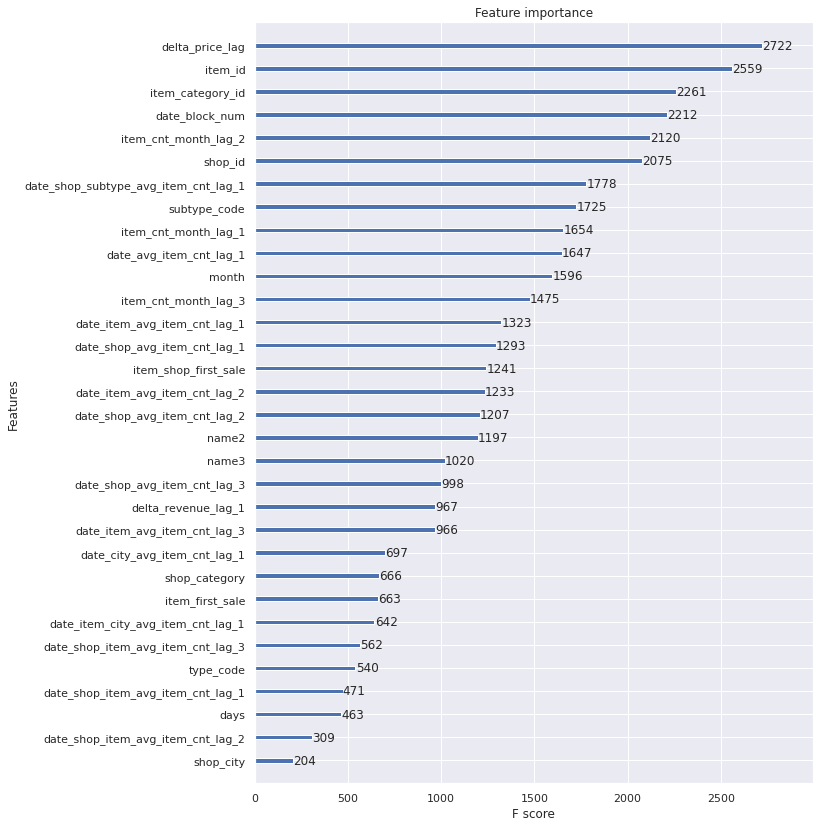

In [100]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))